In [ ]:
import numpy as np
import librosa
import scipy.signal
import matplotlib.pyplot as plt

In [2]:
audio_path = "songs_wav/Reptilia.wav"

In [21]:
def create_audio_fingerprint(audio_path):
    """
    Create an audio fingerprint using the Shazam-like algorithm
    as described in the Wang 2003 paper and implemented in 
    Khatri, Dillingham & Chen 2019
    
    Parameters:
    -----------
    audio_path : str
        Path to the audio file
    
    Returns:
    --------
    fingerprint : list of tuples
        List of (time, frequency) peaks representing the audio fingerprint
    """
    # 1. Load and preprocess the audio
    # Convert to mono (averages the stereo channels) and downsample
    # 8192 Hz is chosen because most relevant audio information is below 4096 Hz
    y, sr = librosa.load(audio_path, mono=True, sr=8192)
    
    # 2. Compute Short-Time Fourier Transform (STFT)
    # Use parameters from the paper:
    # - Window length: 1024
    # - Hop size: 32 (smaller hop size compensates for different start times)
    window_length = 1024
    hop_length = 32
    
    # Compute spectrogram
    # Note: librosa.stft uses a Hann window by default, which is fine for our purposes
    D = librosa.stft(y, n_fft=window_length, hop_length=hop_length)
    
    # 3. Compute spectrogram
    # Alternative: use energy (squared magnitude) instead of just magnitude to emphasise stronger frequency components
    magnitude = np.abs(D)
    
    # 4. Divide frequency bins into logarithmic bands
    num_bands = 6
    
    # Create logarithmic frequency bands
    # The frequency bins go from 0 to Nyquist (4096 Hz)
    # Using logarithmic bands to better match human hearing
    freq_bins = magnitude.shape[0]  # 513 bins
    bands = []
    
    # Create logarithmic band divisions
    # Using exponential spacing to create logarithmic bands
    # Start with 1 instead of 0 to avoid log(0) which is undefined
    band_edges = np.logspace(np.log10(1), np.log10(freq_bins-1), num_bands + 1).astype(int)
    band_edges[0] = 0  # Manually set first edge to 0
    
    for i in range(num_bands):
        start = band_edges[i]
        end = band_edges[i + 1]
        bands.append((start, end))
    
    # 5. For each time frame and each frequency band, find the maximum
    band_peaks = np.zeros_like(magnitude)
    
    for t in range(magnitude.shape[1]):
        for start, end in bands:
            # Extract the magnitude for this band
            band_magnitude = magnitude[start:end, t]
            
            # Find index of max in this band
            if len(band_magnitude) > 0:
                max_idx = np.argmax(band_magnitude) + start
                # Set only the max value to its original value, zero out others
                band_peaks[max_idx, t] = magnitude[max_idx, t]
    
    # 6. Apply max filter to identify local peaks
    # The max filter makes neighbourhoods of pixels have the max value in that neighbourhood
    neighbourhood_size = 30  # 300x300 neighbourhood for local maxima
    max_filtered = scipy.ndimage.maximum_filter(band_peaks, size=(neighbourhood_size, neighbourhood_size))
    
    # 7. Find local maxima by comparing original to max filtered version
    # Only points that are the max in their neighborhood will be the same in both
    peak_mask = (band_peaks == max_filtered) & (band_peaks > 0)
    
    # 8. Get the coordinates of all peak points
    peak_coordinates = np.argwhere(peak_mask)
    
    # Convert to list of (time, frequency) tuples for the fingerprint
    fingerprint = [(time, freq) for freq, time in peak_coordinates]
    
    return fingerprint

fingerprint_1 = create_audio_fingerprint(audio_path)

In [31]:
def create_fingerprint_pairs(fingerprint, target_zone_frames=50):
    """
    Create pairs from fingerprint peaks
    
    Parameters:
    -----------
    fingerprint : list of tuples
        List of (time, frequency) peaks
    target_zone_frames : int
        Number of frames to the right of anchor point to consider
    
    Returns:
    --------
    pairs : list of tuples
        List of (freq_1, freq_2, delta_t) pairs
    """
    pairs = []
    
    # Sort peaks by time
    sorted_peaks = sorted(fingerprint, key=lambda x: x[0])

    # Create pairs
    for i, anchor_point in enumerate(sorted_peaks):
        anchor_time, anchor_freq = anchor_point
        
        # Look at peaks within target zone
        for j in range(i+1, len(sorted_peaks)):
            target_point = sorted_peaks[j]
            target_time, target_freq = target_point
            
            # Check if the target point is within the target zone (50 frames to the right)
            time_diff = target_time - anchor_time
            if time_diff > target_zone_frames:
                break  # We've gone beyond the target zone
                
            # Create pair
            pair = (anchor_freq, target_freq, time_diff)
            pairs.append(pair)
    
    return pairs

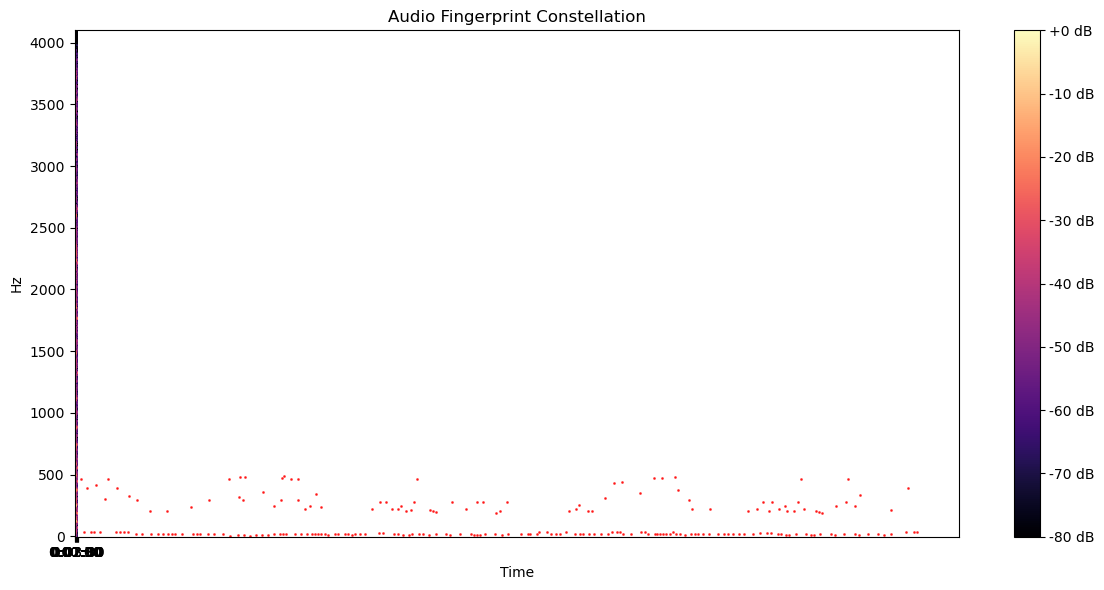

In [48]:
# fingerprint = create_audio_fingerprint(audio_path)
# pairs = create_fingerprint_pairs(fingerprint, 50)

def plot_fingerprint(audio_path):
    """
    Create and visualize the fingerprint constellation
    """
    # Get the fingerprint
    fingerprint = create_audio_fingerprint(audio_path)
    
    # Load audio for visualization
    y, sr = librosa.load(audio_path, mono=True, sr=8192)
    
    # Compute spectrogram for visualization
    D = librosa.stft(y, n_fft=1024, hop_length=32)
    magnitude = np.abs(D)**2
    magnitude_db = librosa.power_to_db(magnitude, ref=np.max)
    
    # Plot spectrogram
    plt.figure(figsize=(12, 6))
    librosa.display.specshow(magnitude_db, sr=sr, hop_length=32, x_axis='time', y_axis='hz')
    plt.xticks(np.arange(0, len(y)/sr, 30))
    plt.colorbar(format='%+2.0f dB')
    
    # Plot the fingerprint points on top
    time_points = [f[0] for f in fingerprint]
    freq_points = [f[1] for f in fingerprint]
    plt.scatter(time_points, freq_points, color='red', s=1, alpha=0.7)
    
    plt.title('Audio Fingerprint Constellation')
    plt.tight_layout()
    plt.show()

plot_fingerprint(audio_path)

In [30]:
def create_fingerprint_database(song_files, output_pickle, output_json):
    """
    Create a fingerprint database from a list of song files.
    
    Args:
        song_files: List of (track_id, file_path) tuples
        output_pickle: Path to save the database as pickle
        output_json: Path to save the database as JSON
    """
    database = {}  # {hash_value: [(track_id, time_offset), ...]}
    
    for track_id, file_path in song_files:
        # Extract fingerprint from audio file
        fingerprint = create_audio_fingerprint(file_path)
        
        # Generate fingerprint pairs
        pairs = create_fingerprint_pairs(fingerprint)
        
        # Add to database
        for i, (freq1, freq2, delta_t) in enumerate(pairs):
            hash_value = hash_function(freq1, freq2, delta_t)
            time_offset = fingerprint[i][0]  # Time of the anchor point
            
            if hash_value not in database:
                database[hash_value] = []
            
            database[hash_value].append((track_id, time_offset))
    
    # Save database to pickle file (binary format, more efficient for loading)
    with open(output_pickle, 'wb') as f:
        pickle.dump(database, f)
    
    # Convert database to JSON-compatible format 
    # (JSON keys must be strings, not integers)
    json_database = {str(key): value for key, value in database.items()}
    
    # Save database to JSON file (human-readable)
    with open(output_json, 'w') as f:
        json.dump(json_database, f)
    
    print(f"Database created with {len(database)} unique hashes")
    print(f"Saved as pickle: {output_pickle}")
    print(f"Saved as JSON: {output_json}")

In [ ]:
create_fingerprint_database(song_files, "output.pkl", "output.json")

In [32]:
def hash_function(freq1, freq2, delta_t):
    """
    Create a compact hash from the fingerprint components.
    Assumes freq1, freq2 are 10-bit values and delta_t is a 10-bit value.
    """
    # Pack into a 32-bit integer
    # Use bit shifting to compose the hash
    return (freq1 << 20) | (freq2 << 10) | delta_t